In [2]:
import shap
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [3]:
original_df = pd.read_csv("../0. Data/classification_data.csv")
original_df = original_df.drop(columns=["Recycle ratio (total return sludge flow/total influent flow).1"])
original_df.columns.to_list()

['Sample',
 'Position',
 'Country',
 'City',
 'Plant',
 'Date',
 'Volume of aeration tanks (m3)',
 'Actual Inf rate (m3/d)',
 '℃ Temp.Max.SamplingDate',
 '℃ Temp.Avg.SamplingDate',
 '℃ Temp.Min.SamplingDate',
 '℃ Dew.Max.SamplingDate',
 '℃ Dew.Avg.SamplingDate',
 '℃ Dew.Min.SamplingDate',
 '℃ Humidity.Max.SamplingDate',
 '℃ Humidity.Min.SamplingDate',
 '℃ Wind.Max.SamplingDate',
 '℃ Wind.Min.SamplingDate',
 '℃ Pressure.Max.SamplingDate',
 '℃ Pressure.Min.SamplingDate',
 '℃ Precipitation.SamplingDate',
 '℃ Temp.Max.WeekMean',
 '℃ Temp.Avg.WeekMean',
 '℃ Temp.Min.WeekMean',
 '℃ Dew.Max.WeekMean',
 '℃ Dew.Avg.WeekMean',
 '℃ Dew.Min.WeekMean',
 '℃ Humidity.Max.WeekMean',
 '℃ Humidity.Min.WeekMean',
 '℃ Wind.Max.WeekMean',
 '℃ Wind.Min.WeekMean',
 '℃ Pressure.Max.WeekMean',
 '℃ Pressure.Min.WeekMean',
 '℃ Precipitation.WeekMean',
 '℃ Temp.Max.WeekMax',
 '℃ Temp.Avg.WeekMax',
 '℃ Temp.Min.WeekMax',
 '℃ Dew.Max.WeekMax',
 '℃ Dew.Avg.WeekMax',
 '℃ Dew.Min.WeekMax',
 '℃ Humidity.Max.WeekMax',
 

In [4]:
as_list = [
    'NewcastleAS', 'VarbergAS', 'SFAS',
    'Beijing3AS', 'Beijing2AS', 'GuangzhouAS',
    'KnoxvilleASP1', 'KnoxvilleASP2', 'KnoxvilleASP3',
    'DurbanASP1', 'DurbanASP2', 'DurbanASP3', 'DurbanASP4',
    'LisbonAS', 'ChicagoAS',
    'NormanASP1', 'NormanASP2', 'NormanASP3'
]

filtered_df = original_df[original_df["Position"].isin(as_list)]


In [5]:
filtered_df.Sample.unique()

array(['UK01A', 'UK02A', 'UK03A', 'UK04A', 'UK05A', 'UK06A', 'UK08A',
       'UK09A', 'UK10A', 'UK11A', 'UK12A', 'UK13A', 'UK14A', 'UK15A',
       'UK16A', 'UK17A', 'UK18A', 'UK19A', 'UK20A', 'UK21A', 'UK22A',
       'UK23A', 'UK24A', 'UK25A', 'UK26A', 'UK27A', 'UK28A', 'UK29A',
       'UK30A', 'UK31A', 'UK32A', 'UK33A', 'UK34A', 'UK35A', 'UK36A',
       'UK37A', 'UK38A', 'UK39A', 'UK40A', 'UK41A', 'UK42A', 'UK43A',
       'UK44A', 'UK45A', 'UK46A', 'UK47A', 'UK48A', 'UK49A', 'UK50A',
       'UK51A', 'UK52A', 'SE1A', 'SE2A', 'SE3A', 'SE4A', 'SE5A', 'SE6A',
       'SE7A', 'SE8A', 'SE9A', 'SE10A', 'SE11A', 'SE12A', 'SE13A',
       'SE14A', 'SE15A', 'SE16A', 'SE17A', 'SE18A', 'SE19A', 'SE20A',
       'SE21A', 'SE22A', 'SE23A', 'SE24A', 'SE25A', 'SE26A', 'SE27A',
       'SE28A', 'SE29A', 'SE30A', 'SE31A', 'SE32A', 'SE33A', 'SE34A',
       'SE35A', 'SE36A', 'SE37A', 'SE38A', 'SE39A', 'SE40A', 'SE41A',
       'SE42A', 'SE43A', 'SE44A', 'SE45A', 'SE46A', 'SE47A', 'SE48A',
       'SE49A', 'SE5

In [6]:
X_svd_df = pd.read_csv("../0. Data/ESV_SVD_25D.csv", index_col=0)
X_svd_df

,SVD_1,SVD_2,SVD_3,SVD_4,SVD_5,SVD_6,SVD_7,SVD_8,SVD_9,SVD_10,...,SVD_16,SVD_17,SVD_18,SVD_19,SVD_20,SVD_21,SVD_22,SVD_23,SVD_24,SVD_25
UK01A,119.512586,30.206870,257.892781,244.542209,1476.170952,-886.607324,877.460751,-748.717582,-459.228337,-222.319253,...,359.310911,-89.069847,35.938781,-80.955725,74.555696,204.643887,-44.432424,-75.566567,-28.152542,-139.776911
UK02A,184.855875,44.575649,394.888152,340.562363,2222.852732,-1271.239892,1316.628486,-1090.680760,-736.107534,-323.143894,...,590.358520,-68.025554,-130.805420,-132.906720,124.226026,291.279505,-43.424642,-21.048832,-121.881068,-222.789861
UK03A,176.093600,47.116199,391.320514,351.139450,2224.944927,-1291.757728,1319.204476,-1115.554144,-725.117653,-331.408948,...,573.401686,-61.099369,-127.653732,-125.362428,118.647594,264.290790,-21.878628,-38.734378,-73.757111,-183.435814
UK04A,188.055920,45.143048,405.899105,335.812563,2275.728090,-1367.835375,1378.402861,-1152.497381,-787.089174,-359.224185,...,598.514885,-104.100813,-251.199593,-164.765123,188.262919,316.618341,-25.531131,10.909645,-205.971329,-358.286225
UK05A,183.131358,45.603622,414.252648,326.158036,2297.905647,-1415.437251,1424.057599,-1168.939447,-812.225139,-382.059660,...,649.802823,-171.539529,-265.680254,-160.743738,161.550729,365.633693,-83.970978,-1.510278,-207.412524,-486.803164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GZ101,494.238896,-38.824252,31.679222,121.701359,359.688041,-1.272138,50.041731,354.381228,781.470751,212.451309,...,-112.166328,58.385814,102.919704,72.808057,-94.706035,-13.287829,140.859177,199.582808,72.440998,-135.446180
GZ102,305.125160,42.983298,41.087944,183.634098,399.361700,15.441426,74.218017,416.102790,817.795276,118.619032,...,-79.298511,51.476070,23.173439,75.400952,-81.106475,-41.925868,50.742185,150.559234,90.515057,-98.718260
GZ103,189.396822,91.082964,48.823397,181.868279,492.019812,38.842927,82.219243,506.441452,1299.410536,137.176615,...,-100.969706,23.984718,-30.219658,158.638139,-247.486326,36.096102,117.122560,71.440781,237.915310,-110.151610
GZ104,156.687353,127.642448,46.379917,193.862037,501.665470,40.127084,70.643125,529.404743,1460.791904,158.691635,...,-103.062245,-62.725783,-0.736163,183.274059,-249.849197,1.157861,190.774279,53.071887,324.480931,-144.010866


In [7]:

filtered_df_indexed = filtered_df.set_index("Sample")

# X_svd_df와 병합
merged_df = filtered_df_indexed.join(X_svd_df, how="inner")

# 결과 확인
print(merged_df.shape)
merged_df


(813, 115)


,Position,Country,City,Plant,Date,Volume of aeration tanks (m3),Actual Inf rate (m3/d),℃ Temp.Max.SamplingDate,℃ Temp.Avg.SamplingDate,℃ Temp.Min.SamplingDate,...,SVD_16,SVD_17,SVD_18,SVD_19,SVD_20,SVD_21,SVD_22,SVD_23,SVD_24,SVD_25
UK01A,NewcastleAS,United Kindom,Newcastle,UKTM1A,2015-01-28,3600.0,17254.0,6.67,3.33,0.56,...,359.310911,-89.069847,35.938781,-80.955725,74.555696,204.643887,-44.432424,-75.566567,-28.152542,-139.776911
UK02A,NewcastleAS,United Kindom,Newcastle,UKTM1A,2015-02-04,3600.0,7007.0,5.56,3.33,0.56,...,590.358520,-68.025554,-130.805420,-132.906720,124.226026,291.279505,-43.424642,-21.048832,-121.881068,-222.789861
UK03A,NewcastleAS,United Kindom,Newcastle,UKTM1A,2015-02-11,3600.0,7197.0,5.56,4.44,2.78,...,573.401686,-61.099369,-127.653732,-125.362428,118.647594,264.290790,-21.878628,-38.734378,-73.757111,-183.435814
UK04A,NewcastleAS,United Kindom,Newcastle,UKTM1A,2015-02-18,3600.0,6126.0,11.67,10.00,8.89,...,598.514885,-104.100813,-251.199593,-164.765123,188.262919,316.618341,-25.531131,10.909645,-205.971329,-358.286225
UK05A,NewcastleAS,United Kindom,Newcastle,UKTM1A,2015-02-25,3600.0,6898.0,10.56,7.78,5.56,...,649.802823,-171.539529,-265.680254,-160.743738,161.550729,365.633693,-83.970978,-1.510278,-207.412524,-486.803164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
N48C,NormanASP3,United States,Norman,USNO2,2015-12-23,9751.2,31922.0,20.56,9.44,-1.67,...,79.002384,-127.434802,376.146945,19.078335,-74.248669,103.338832,-214.610152,-190.040699,242.680544,205.719815
N49C,NormanASP3,United States,Norman,USNO2,2015-12-30,9751.2,45538.0,0.56,-2.22,-5.56,...,16.530354,-34.585756,301.029151,29.531855,43.658539,-140.688473,100.361306,230.568493,-241.501097,-234.927432
N50C,NormanASP3,United States,Norman,USNO2,2016-01-06,9751.2,39274.0,11.67,8.33,4.44,...,-78.089860,-222.846491,431.170700,38.761832,-266.749614,451.700897,-581.428367,-649.538278,782.778535,448.260753
N51C,NormanASP3,United States,Norman,USNO2,2016-01-13,9751.2,34284.0,14.44,5.56,-3.33,...,-178.605008,-386.187801,824.720211,23.364556,-232.236579,570.914432,-596.004992,-930.312088,916.910955,438.088537


## Time-series data seperation


In [8]:
# def make_sequences(df, feature_cols, target_cols, input_len=3, target_len=1):
#     X_seq, y_seq = [], []
    
#     for plant, group_df in df.groupby("Plant"):
#         group_df = group_df.sort_values("Date")
#         values = group_df[feature_cols + target_cols].values
        
#         for i in range(len(values) - input_len - target_len + 1):
#             X_window = values[i:i+input_len, :len(feature_cols)]
#             y_window = values[i+input_len:i+input_len+target_len, len(feature_cols):]
#             X_seq.append(X_window)
#             y_seq.append(y_window)
#             print(X_window)
    
#     X_seq = np.array(X_seq)
#     y_seq = np.array(y_seq).squeeze()  # (N, target_len, target_dim) → (N, target_dim)
#     return X_seq, y_seq
def make_shifted_sequences(df, feature_cols, target_cols, input_len=3):
    X_all, y_all = [], []

    for plant, group_df in df.groupby("Plant"):
        group_df = group_df.sort_values("Date").reset_index(drop=True)
        # print(group_df)

        total_steps = len(group_df)

        for i in range(input_len, total_steps - 1):
            # 과거 3 스텝: features + targets
            X_past = group_df.iloc[i-input_len:i][feature_cols + target_cols].values

            # 현재 스텝: features + dummy targets (0)
            current_feat = group_df.iloc[i][feature_cols].values
            dummy_targets = np.zeros(len(target_cols))  # 또는 np.nan
            X_future = np.concatenate([current_feat, dummy_targets]).reshape(1, -1)

            # 입력 시퀀스: 4 스텝
            X_input = np.vstack([X_past, X_future])

            # 타겟은 현재 시점의 target 값
            y_target = group_df.iloc[i][target_cols].values

            X_all.append(X_input)
            y_all.append(y_target)

    return np.array(X_all), np.array(y_all)



In [9]:
# NaN 비율 계산
nan_ratio = merged_df.isna().mean()

# 30% 이하인 컬럼만 선택
merged_df = merged_df.loc[:, nan_ratio <= 0.3]

merged_df["pH AS"] = pd.to_numeric(merged_df["pH AS"], errors="coerce")

# 2. inf, -inf → NaN으로 변환
merged_df = merged_df.replace([np.inf, -np.inf], np.nan)

# 3. 남은 NaN을 컬럼 평균으로 채움
merged_df = merged_df.fillna(merged_df.mean(numeric_only=True))


/var/folders/c9/14_8p05x241fyxw1d_hqydvr0000gq/T/ipykernel_29608/457672170.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df["pH AS"] = pd.to_numeric(merged_df["pH AS"], errors="coerce")


In [14]:


# 예측 대상 (SVD_로 시작하는 컬럼들)
target_columns = [col for col in merged_df.columns if col.startswith("SVD_")]

# 전체 피처 중에서 SVD가 아닌 컬럼들만 입력값으로 사용
feature_columns = [ 'Volume of aeration tanks (m3)', 'Actual Inf rate (m3/d)', '℃ Temp.Max.SamplingDate', '℃ Temp.Avg.SamplingDate', '℃ Temp.Min.SamplingDate',
 '℃ Dew.Max.SamplingDate', '℃ Dew.Avg.SamplingDate', '℃ Dew.Min.SamplingDate', '℃ Humidity.Max.SamplingDate', '℃ Humidity.Min.SamplingDate', '℃ Wind.Max.SamplingDate', '℃ Wind.Min.SamplingDate',
 '℃ Pressure.Max.SamplingDate', '℃ Pressure.Min.SamplingDate', '℃ Precipitation.SamplingDate', '℃ Temp.Max.WeekMean', '℃ Temp.Avg.WeekMean', '℃ Temp.Min.WeekMean', '℃ Dew.Max.WeekMean', '℃ Dew.Avg.WeekMean',
 '℃ Dew.Min.WeekMean', '℃ Humidity.Max.WeekMean', '℃ Humidity.Min.WeekMean', '℃ Wind.Max.WeekMean', '℃ Wind.Min.WeekMean', '℃ Pressure.Max.WeekMean', '℃ Pressure.Min.WeekMean', '℃ Precipitation.WeekMean',
 '℃ Temp.Max.WeekMax', '℃ Temp.Avg.WeekMax', '℃ Temp.Min.WeekMax', '℃ Dew.Max.WeekMax', '℃ Dew.Avg.WeekMax', '℃ Dew.Min.WeekMax', '℃ Humidity.Max.WeekMax', '℃ Humidity.Min.WeekMax', '℃ Wind.Max.WeekMax',
 '℃ Wind.Min.WeekMax', '℃ Pressure.Max.WeekMax', '℃ Pressure.Min.WeekMax', '℃ Precipitation.WeekMax', '℃ Precipitation.WeekAccum', '℃ Precipitation.MonthAccum', 'COD (mg/l) In', 'COD (mg/l) Out',
 'NH3 (mg/L) In', 'NH3 (mg/L) Out', 'Total Phosphorus (mg/L) In', 'Total Phosphorus (mg/L) Out', 'pH AS', 'DO (mg/L) AS', 'Temp (oC) AS', 'MLSS (mg/l) AS', 'MLVSS (mg/l) AS', 'SRT (days)', 'Q* (%)',
 'COD Removal Rate (mg/L/h)', 'COD Removal Efficiency (%)', 'COD_influent_rate (g/l/h)', 'efficiency']

X, y = make_shifted_sequences(merged_df, feature_columns, target_columns, input_len=1)

print("X shape:", X.shape)  # (samples, 4, features + targets) → 마지막 스텝은 features만
print("y shape:", y.shape)  # (samples, target_dim)


X shape: (791, 2, 85)
y shape: (791, 25)


In [15]:
split_idx = int(len(X) * 0.7)

X_train = X[:split_idx]
X_val   = X[split_idx:]

y_train = y[:split_idx]
y_val   = y[split_idx:]

print('train: ', len(X_train), len(y_train), 'test: ', len(X_val), len(y_val))


train:  553 553 test:  238 238


In [16]:
# X: 3D array (samples, timesteps, features)
X_train = X_train.astype(np.float32)
X_val = X_val.astype(np.float32)


# y: 2D array (samples, target_dim)
y_train = y_train.astype(np.float32)
y_val = y_val.astype(np.float32)


## LSTM model development

In [17]:

model = Sequential([
    LSTM(128, input_shape=(X.shape[1], X.shape[2]), return_sequences=False),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(y.shape[1])  # 출력 노드 수 = 타겟 변수 수 (25개)
])

model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)



/Users/k23070952/.local/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [18]:
early_stop = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=500,
    batch_size=32,
    callbacks=[early_stop]
)


Epoch 1/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 895382.1250 - mae: 362.5787 - val_loss: 680234.5625 - val_mae: 421.2241
Epoch 2/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 847356.4375 - mae: 362.6956 - val_loss: 679851.9375 - val_mae: 421.0240
Epoch 3/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 773166.5000 - mae: 355.3792 - val_loss: 679226.6250 - val_mae: 420.7189
Epoch 4/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 811277.7500 - mae: 356.0883 - val_loss: 678283.5000 - val_mae: 420.2503
Epoch 5/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 815051.5625 - mae: 354.6869 - val_loss: 676833.8125 - val_mae: 419.5690
Epoch 6/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 737429.2500 - mae: 347.1886 - val_loss: 674801.5000 - val_mae: 418.6806
Epoch 7/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 902263.4375 - mae: 367.4622 - val_loss: 672452.2500 - val_mae: 417.7437
Epoch 8/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 795214.6875 - mae: 352.6

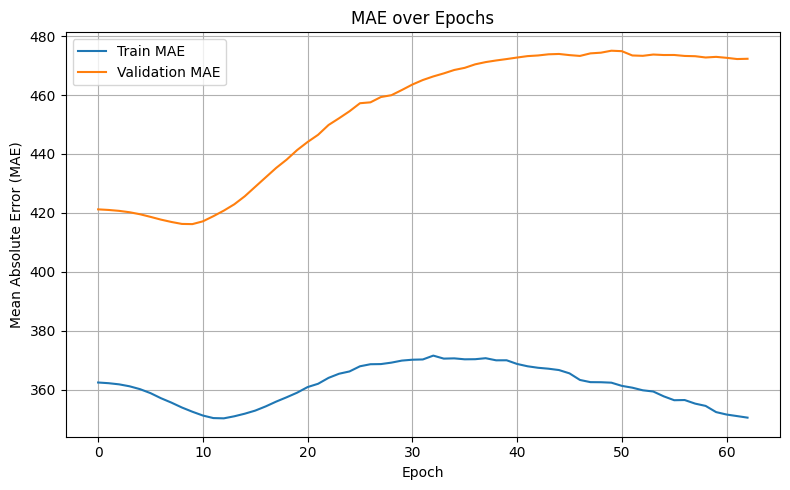

In [19]:
# history 객체에서 MAE 값 꺼내기
train_mae = history.history["mae"]
val_mae = history.history["val_mae"]

# 시각화
plt.figure(figsize=(8, 5))
plt.plot(train_mae, label="Train MAE")
plt.plot(val_mae, label="Validation MAE")
plt.xlabel("Epoch")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("MAE over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:


# 모델 구조 예시
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate
from tensorflow.keras.models import Model



# 1. LSTM은 과거 3스텝만
X_lstm = X[:, :1, :]  # (N, 3, F+T)

# 2. 현재 시점 feature만 별도 추출
X_now = X[:, 1, :len(feature_columns)]  # (N, F)

# X: 3D array (samples, timesteps, features)
X_lstm = X_lstm.astype(np.float32)
X_now = X_now.astype(np.float32)
y = y.astype(np.float32)

from sklearn.preprocessing import StandardScaler

# 시계열 입력 X_lstm (3D → 2D → scaling → 3D)
scaler_lstm = StandardScaler()
X_lstm_flat = X_lstm.reshape(-1, X_lstm.shape[2])  # (samples × timesteps, features)
X_lstm_scaled = scaler_lstm.fit_transform(X_lstm_flat)
X_lstm_scaled = X_lstm_scaled.reshape(X_lstm.shape)

# 현재 시점 입력 X_now (2D)
scaler_now = StandardScaler()
X_now_scaled = scaler_now.fit_transform(X_now)


from sklearn.model_selection import train_test_split

# 전체 샘플 수
n_samples = X_lstm_scaled.shape[0]

# 70% 지점 기준 인덱스
split_index = int(n_samples * 0.7)

# 시간 순서 그대로 유지해서 split
X_train_lstm = X_lstm_scaled[:split_index]
X_test_lstm = X_lstm_scaled[split_index:]

X_train_now = X_now_scaled[:split_index]
X_test_now = X_now_scaled[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

print("X_train_lstm:", X_train_lstm.shape)
print("X_train_now:", X_train_now.shape)
print("y_train:", y_train.shape)

print("X_test_lstm:", X_test_lstm.shape)
print("X_test_now:", X_test_now.shape)
print("y_test:", y_test.shape)



X_train_lstm: (553, 1, 85)
X_train_now: (553, 60)
y_train: (553, 25)
X_test_lstm: (238, 1, 85)
X_test_now: (238, 60)
y_test: (238, 25)


In [21]:
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization, Concatenate
from tensorflow.keras.models import Model

# 입력
input_seq = Input(shape=(1, X.shape[2]))  # 과거 시계열: features + targets
input_now = Input(shape=(len(feature_columns),))  # 현재 시점 features

# LSTM 블록
x_seq = LSTM(128, return_sequences=True)(input_seq)
x_seq = LSTM(64)(x_seq)  # 두 번째 LSTM
x_seq = Dense(32, activation='relu')(x_seq)

# 현재 시점 블록
x_now = Dense(64, activation='relu')(input_now)
x_now = Dropout(0.3)(x_now)
x_now = Dense(32, activation='relu')(x_now)

# 병합
combined = Concatenate()([x_seq, x_now])
x = Dense(128, activation='relu')(combined)
x = Dense(32, activation='relu')(x)

# 출력
output = Dense(y.shape[1])(x)

# 모델 정의
model = Model(inputs=[input_seq, input_now], outputs=output)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])


In [22]:
early_stop = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
history = model.fit(
    [X_train_lstm, X_train_now], y_train,
    validation_data=([X_test_lstm, X_test_now], y_test),
    epochs=500,
    batch_size=5,
    callbacks=[early_stop]  # 선택
)


Epoch 1/500


/Users/k23070952/.local/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_10', 'keras_tensor_11']. Received: the structure of inputs=('*', '*')
  warnings.warn(


111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 813183.3750 - mae: 351.0352 - val_loss: 686993.6250 - val_mae: 438.7300
Epoch 2/500
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 604960.8750 - mae: 364.3508 - val_loss: 706462.5000 - val_mae: 438.5726
Epoch 3/500
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 389788.7812 - mae: 291.4454 - val_loss: 715708.9375 - val_mae: 438.8288
Epoch 4/500
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 317754.1562 - mae: 274.1658 - val_loss: 740269.6875 - val_mae: 446.6907
Epoch 5/500
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 312713.5000 - mae: 282.4921 - val_loss: 757064.6250 - val_mae: 451.4565
Epoch 6/500
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 296018.9688 - mae: 286.5729 - val_loss: 750795.1875 - val_mae: 453.1470
Epoch 7/500
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 242536.1250 - mae: 274.7290 - val_loss: 758743.5000 - val_mae: 452.7039
Epoch 8/500
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 240394.1875 - mae: 2

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step


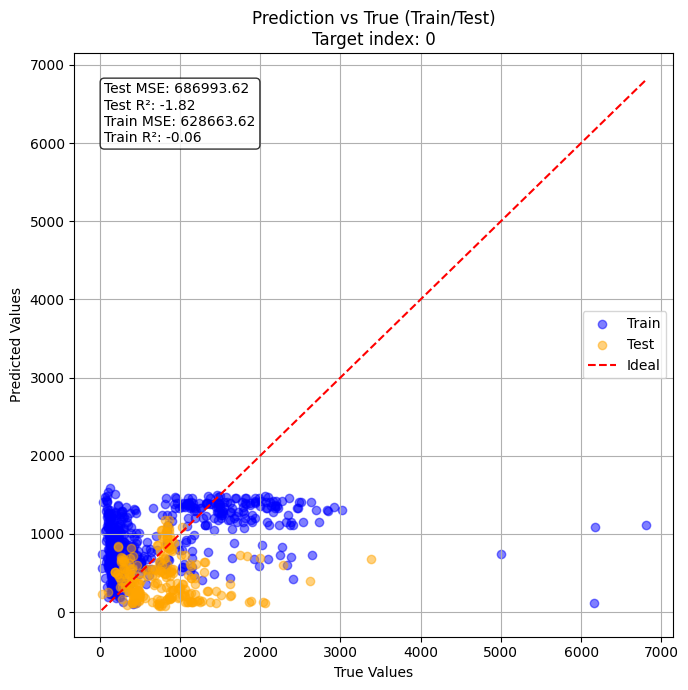

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# 예측값 (모델 예측 후 얻은 값)
y_train_pred = model.predict([X_train_lstm, X_train_now])
y_test_pred = model.predict([X_test_lstm, X_test_now])

# 성능 지표 계산
mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

# 하나의 타겟만 그릴 경우 (예: 첫 번째 타겟)
target_index = 0

plt.figure(figsize=(7, 7))

# Train set (파란색)
plt.scatter(y_train[:, target_index], y_train_pred[:, target_index],
            alpha=0.5, label='Train', color='blue')

# Test set (주황색)
plt.scatter(y_test[:, target_index], y_test_pred[:, target_index],
            alpha=0.5, label='Test', color='orange')

# 대각선 (예측 = 실제)
min_val = min(y_train[:, target_index].min(), y_test[:, target_index].min(),
              y_train_pred[:, target_index].min(), y_test_pred[:, target_index].min())
max_val = max(y_train[:, target_index].max(), y_test[:, target_index].max(),
              y_train_pred[:, target_index].max(), y_test_pred[:, target_index].max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal')

# Label, title, legend
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title(f"Prediction vs True (Train/Test)\nTarget index: {target_index}")
plt.legend()
plt.grid(True)

# 성능 지표 텍스트 박스
textstr = f"""Test MSE: {mse_test:.2f}
Test R²: {r2_test:.2f}
Train MSE: {mse_train:.2f}
Train R²: {r2_train:.2f}"""
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()
